In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imshow
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [2]:
def visualise_history(hist):
    measures = []
    for measure in hist.history.keys():
        if 'val' not in measure:
            measures.append(measure)
    # measures = ['loss', 'accuracy', 'f1_score']

    fig, ax = plt.subplots(3)
    
    for i, measure in enumerate(measures):
        val_measure = 'val_' + measure
        ax[i].plot(hist.history[measure])
        ax[i].set_title(measure)
        ax[i].plot(hist.history[val_measure])
        ax[i].set_title(val_measure)
        # ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(measure)
    plt.xlabel('epochs')
    plt.show()

def visualise_prediction(img, ground_truth):
    true_img = img.copy()
    img = np.expand_dims(img, axis=0)
    y_pred = unet.predict(img)

    f, ax = plt.subplots(1,3)
    pred_mask = tf.argmax(y_pred[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    # masked_img = np.zeros
    # masked_img[pred_mask == 0] = 0 
    # print(true_img.shape)
    # print(pred_mask[:,:,0].shape)
    ax[0].imshow(true_img)
    ax[1].imshow(pred_mask[:,:,0])
    ax[2].imshow(ground_truth)
    # ax[2].imshow(pred_mask[:,:,0] * true_img, cmap='gray')


    plt.show()

In [3]:
input_dir = 'pets/images'
target_dir = 'pets/trimaps'

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [4]:
IMG_WIDTH_HEIGHT = 128
IMG_CHANNELS = 3
classes = 2

In [5]:


X = np.zeros((len(input_img_paths), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 3), dtype=np.float32)
Y = np.zeros((len(input_img_paths), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 1), dtype=np.uint8)
for i in range(len(input_img_paths)):
    img_path = input_img_paths[i]
    img = load_img(img_path, grayscale=False, target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) # removed grayscale mode
    img = img_to_array(img)
    X[i] = img.astype('float32') / 255.0
    
    mask_path = target_img_paths[i]
    mask = load_img(mask_path, grayscale=True,target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) 
    mask = img_to_array(mask)
    Y[i] = mask - 1
print('Mask correction')

Y[Y==2] = 1

c:\Users\Adam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Mask correction


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True)

In [7]:
print(f'X train shape: {x_train.shape}')
print(f'X test shape: {x_test.shape}')
print(f'Y train shape: {y_train.shape}')
print(f'Y test shape: {y_test.shape}')


X train shape: (6281, 128, 128, 3)
X test shape: (1109, 128, 128, 3)
Y train shape: (6281, 128, 128, 1)
Y test shape: (1109, 128, 128, 1)


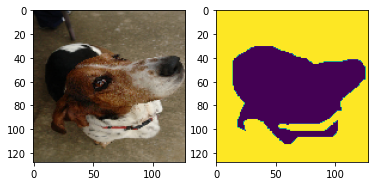

array([0, 1], dtype=uint8)

In [8]:
f, ax = plt.subplots(1,2)

k = 33
ax[0].imshow(x_test[k])
ax[1].imshow(y_test[k])
plt.show()
np.unique(y_test[k])

In [9]:
def encoder_block(input= None, n_filters = 64, dropout_rate = 0.0, max_pooling=True):
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(input)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    if dropout_rate > 0:
        conv = Dropout(dropout_rate)(conv)    
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)     
    else:
        next_layer = conv   
    #conv = BatchNormalization()(conv)
    skip_connection = conv
    
    return next_layer, skip_connection



def decoder_block(input, copy_crop_input, n_filters=64):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(input)
    
    merge = concatenate([up, copy_crop_input], axis=3)

    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    return conv

In [10]:
def unet_model(input_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT
                           , IMG_CHANNELS), n_filters=64, n_classes=2):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = encoder_block(inputs, n_filters)
    cblock2 = encoder_block(cblock1[0], 2*n_filters)
    cblock3 = encoder_block(cblock2[0], 4*n_filters)
    cblock4 = encoder_block(cblock3[0], 8*n_filters, dropout_rate=0.2) 
    cblock5 = encoder_block(cblock4[0],16*n_filters, dropout_rate=0.2, max_pooling=None)     
    
    #expanding path
    ublock6 = decoder_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = decoder_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = decoder_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = decoder_block(ublock8,cblock1[1],  n_filters)
    conv9 = Conv2D(n_classes,
                 kernel_size = 1,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    #conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation = 'softmax')(conv9) 
    conv10 = Activation('softmax')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [12]:
tf.keras.backend.clear_session()
unet = unet_model((IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS), n_filters=64, n_classes=classes)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [13]:
epochs = 25
unet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_history = unet.fit(x_train, y_train, batch_size=16, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/25
393/393 [==============================] - 59s 138ms/step - loss: 0.4978 - accuracy: 0.7720 - val_loss: 0.4401 - val_accuracy: 0.8061
Epoch 2/25
393/393 [==============================] - 51s 131ms/step - loss: 0.4465 - accuracy: 0.8014 - val_loss: 0.4210 - val_accuracy: 0.8178
Epoch 3/25
393/393 [==============================] - 51s 131ms/step - loss: 0.4266 - accuracy: 0.8195 - val_loss: 0.3964 - val_accuracy: 0.8461
Epoch 4/25
393/393 [==============================] - 51s 131ms/step - loss: 0.3944 - accuracy: 0.8462 - val_loss: 0.3431 - val_accuracy: 0.8604
Epoch 5/25
393/393 [==============================] - 51s 131ms/step - loss: 0.3026 - accuracy: 0.8725 - val_loss: 0.2545 - val_accuracy: 0.8930
Epoch 6/25
393/393 [==============================] - 51s 131ms/step - loss: 0.2521 - accuracy: 0.8950 - val_loss: 0.2456 - val_accuracy: 0.8969
Epoch 7/25
393/393 [==============================] - 51s 131ms/step - loss: 0.2285 - accuracy: 0.9054 - val_loss: 0.2731 - val_ac

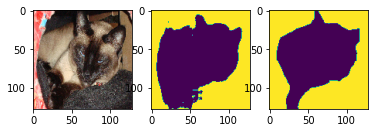

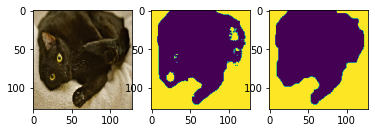

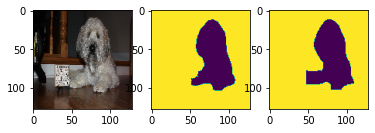

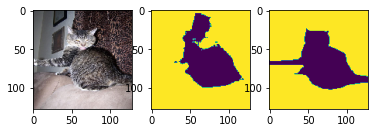

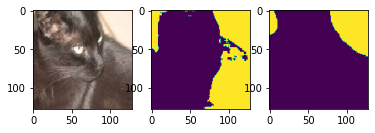

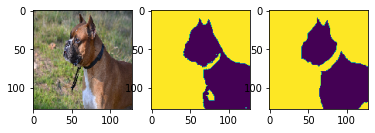

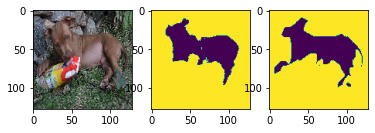

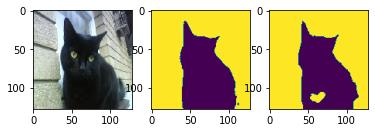

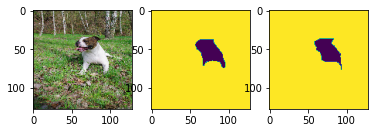

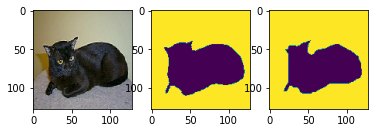

In [16]:
for j in range(1000,1010):
    visualise_prediction(x_test[j], y_test[j])

35/35 [==============================] - 6s 117ms/step - loss: 0.1814 - accuracy: 0.9352


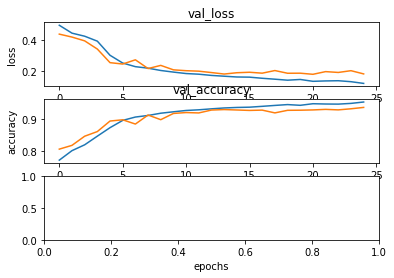

In [14]:
unet.evaluate(x_test, y_test)
visualise_history(model_history)